In [2]:
from abnativ.model.scoring_functions import abnativ_scoring
from abnativ.model.alignment.mybio import distance_matrix_from_aligned_sequences
import pickle
import random
from Bio import SeqIO

from camsol import camsol_intrinsic

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import numpy as np

random.seed(11)


/Users/aubinramon/opt/anaconda3/envs/abnativ/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/aubinramon/opt/anaconda3/envs/abnativ/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
/Users/aubinramon/opt/anaconda3/envs/abnativ/lib/python3.8/site-packages/Bio/SeqUtils/CodonUsageIndices.py:16: BiopythonDeprecationWarning: This module has been DEPRECATED. Please use the CodonAdaptationIndex class in Bio.SeqUtils instead. Note that this class has been updated to use modern Python, and may give slight

In [14]:
# SCORED WITH ABNATIV
n_sampled = 10000
fp_scored_abnativ = f'data/scored_abnativ_10k_VHH.pkl'

In [10]:
## NANOTHERMOSTABILITY PREDICTION WITH PYTHON FILE NANOMELT.PY 
output_savename = 'data/nanomelt_10000_VHH_wally_oas_marks_pdb_avida_shuf_no_dupli_aligned.csv'

In [13]:
# Load and Merge datasets
with open(fp_scored_abnativ, 'rb') as f:
    vh_mean_df = pickle.load(f)
data = pd.read_csv(output_savename)

data = data.rename(columns={'ID': 'seq_id'})
vh_mean_df['seq_id']=vh_mean_df['seq_id'].astype(int)

merge_data = data.merge(vh_mean_df, on='seq_id')

In [15]:
# Filter out low nativeness sequences
nat_threshold = 0.85 

merge_data_85 = merge_data[merge_data['AbNatiV VHH Score']>=nat_threshold]
print(f'-> Selection sequences with nativeness >= {nat_threshold}')
print(f'--->{len(merge_data_85)} are selected out of {n_sampled}')

-> Selection sequences with nativeness >= 0.85
--->7797 are selected out of 10000


In [16]:
# Save into a fasta file
seqs = list(merge_data_85['Aligned Sequence'])
ids = list(merge_data_85['seq_id'])
scores = list(merge_data_85['AbNatiV VHH Score'])

fp_saved_selected_seqs = f'selected_seqs_vhh_{n_sampled}_sampled_{nat_threshold}_nat_treshold.fa'
with open(fp_saved_selected_seqs, 'w') as f:
    for id, seq, score in zip(ids, seqs, scores):
        f.write(f'>{id}_{round(score,2)}\n')
        f.write(seq + '\n')


In [23]:
# Compute distance matrix between everyone
fp_ref_data = 'data/database_640.pkl'
al_ref_seqs = pd.read_pickle(fp_ref_data)['al_seq']

all_al_seqs = list(seqs) + list(al_ref_seqs)

matrix_mut = distance_matrix_from_aligned_sequences(all_al_seqs, return_number_of_mutations=True, 
                                                    only_first_N_sequences=len(seqs), quiet=False)




->>> Compute distance


100%|██████████| 7797/7797 [00:31<00:00, 249.95it/s] 


distance matrix and distance_n_mutations computed for 8437 sequences [only_first_N_sequences=7797], took 38.43997406959534 s


In [25]:
## Normalised nb of mutations with the average AHo length 
norm_matrix_mut = np.zeros((matrix_mut.shape))

for i, seq_nb_mutsin in tqdm(enumerate(matrix_mut)):
    for j, nb_mut in enumerate(seq_nb_mutsin):
        l = (len(all_al_seqs[i].replace('-',''))+len(all_al_seqs[j].replace('-','')))/2
        norm_matrix_mut[i,j] = nb_mut/l

7797it [03:07, 41.56it/s]


In [26]:
## Remove distances to himself
matrix_mut_to_ref = norm_matrix_mut[:,len(seqs):]
print('-> Shape distance matrix to ref database:')
print(matrix_mut_to_ref.shape)

-> Shape distance matrix to ref database:
(7797, 640)


In [27]:
# Take closest 
closest_mut_to_ref = [np.min(dist) for dist in matrix_mut_to_ref]

# Plot closest distrib
sns.set_theme(font_scale = 1)
sns.set_style('white', {'axes.spines.right':False, 'axes.spines.top': False, 'axes.spines.bottom': True,
			'xtick.bottom': True,'xtick.top': False, 'ytick.left': True, 'xtick.labeltop':False})
plt.figure(figsize=(6,6))

database = {'closest': closest_mut_to_ref }

sns.displot(database, x="closest", bins=20, kde=True, color='indianred')

plt.xlabel("Closest edit distance (normalised)", fontsize=10)
plt.ylabel("Count", fontsize=10)

plt.show()
plt.close()

In [28]:
indices_30 = np.where(np.array(closest_mut_to_ref)>0.3)[0]
merge_data_85['closest_dist_mut'] = closest_mut_to_ref
merge_data_85_30 = merge_data_85[merge_data_85['closest_dist_mut']>.3]


/var/folders/hr/1j50v5r91sv8fs_r8qhx8bym0000gn/T/ipykernel_17261/1252189866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_data_85['closest_dist_mut'] = closest_mut_to_ref


58.01 77.42


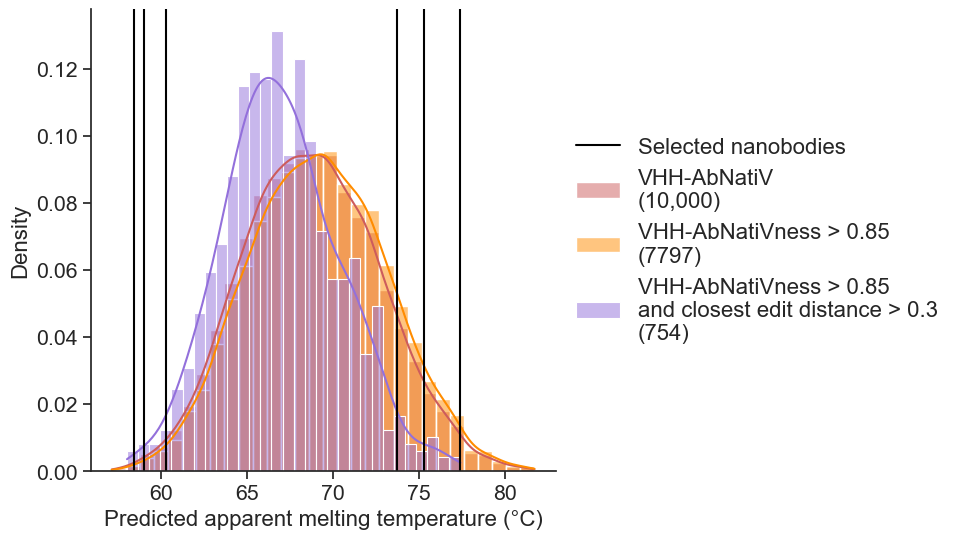

In [48]:
%matplotlib inline
# Get >30 sequences 

# Plot Distributions
sns.set_theme(font_scale = 1.4)
sns.set_style('white', {'axes.spines.right':False, 'axes.spines.top': False, 'axes.spines.bottom': True,
			'xtick.bottom': True,'xtick.top': False, 'ytick.left': True, 'xtick.labeltop':False})
plt.figure(figsize=(6,6))

database_10k = {'ptm': merge_data['NanoMelt Tm (C)']}
database_85AbNatiV = {'ptm': merge_data_85['NanoMelt Tm (C)']}
database_85AbNatiV_30dist = {'ptm': merge_data_85_30['NanoMelt Tm (C)']}


sns.histplot(database_10k, x="ptm", bins=30, kde=True, alpha=0.5, stat='density', color='indianred', label='VHH-AbNatiV\n(10,000)')
sns.histplot(database_85AbNatiV, x="ptm", bins=30, kde=True, alpha=0.5,stat='density', color='darkorange', label=f'VHH-AbNatiVness > 0.85\n({len(merge_data_85)})')
sns.histplot(database_85AbNatiV_30dist, x="ptm", bins=30, kde=True, alpha=0.5,stat='density', color='mediumpurple', label=f'VHH-AbNatiVness > 0.85\nand closest edit distance > 0.3\n({len(merge_data_85_30)})')

plt.axvline(x = 59.0, color = 'black')
plt.axvline(x = 58.4, color = 'black')
plt.axvline(x = 60.3, color = 'black')
plt.axvline(x = 75.3, color = 'black')
plt.axvline(x = 77.4, color = 'black')
plt.axvline(x = 73.7, color = 'black', label = 'Selected nanobodies')


# BVETICAL LINES
plt.xlabel("Predicted apparent melting temperature (°C)", fontsize=16)
plt.ylabel("Density", fontsize=16)

legend = plt.legend(title='',  fontsize=16, markerscale=2,
				  loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

print(min(database_85AbNatiV_30dist['ptm']),max(database_85AbNatiV_30dist['ptm']))
plt.savefig('figures/figureS12.png', dpi=800, bbox_inches='tight', transparent=True)
plt.show()
